# Scalable natural gradients for optimization problems

QNSPSA is an optimizer implemented in Qiskit and we can use it as input with any exisiting algorithm, such as `QAOA` or `VQE`.

In [29]:
from qiskit.algorithms.optimizers import QNSPSA

### Hamiltonian and reference solution

We're looking for the ground state of the following diagonal Hamiltonian on 5 qubits:

$$
\hat H = \hat\sigma_Z^{(1)} \otimes \hat\sigma_Z^{(2)} + \hat\sigma_Z^{(4)} \otimes \hat\sigma_Z^{(5)}
$$

or in Qiskit notation:

In [30]:
from qiskit.opflow import Z, I

H = (Z ^ Z ^ I ^ I ^ I) + (I ^ I ^ I ^ Z ^ Z)  

Which has a ground state energy of

In [42]:
from qiskit.algorithms import NumPyMinimumEigensolver

exact_result = NumPyMinimumEigensolver().compute_minimum_eigenvalue(H)
exact_energy = exact_result.eigenvalue.real
print(exact_energy)

-2.0


### QN-SPSA on a simulator 

To begin, we'll just use a statevector simulator but we can replace it with a real device later on.

In [31]:
from qiskit.providers.aer import AerSimulator
from qiskit.opflow import AerPauliExpectation

sim = AerSimulator()  # simulator for the circuits
exp = AerPauliExpectation()  # expectation value evaluator

Now we can use Qiskit's circuit library to obtain the QAOA ansatz

In [32]:
from qiskit.circuit.library import QAOAAnsatz

ansatz = QAOAAnsatz(H, reps=2)

and based on the ansatz we can define the QN-SPSA optimizer:

In [47]:
fidelity = QNSPSA.get_fidelity(ansatz, backend=sim, expectation=exp)

qnspsa = QNSPSA(fidelity, maxiter=300, learning_rate=0.01, perturbation=0.01)

Let's plug it into the `VQE` to find the ground state:

In [48]:
import numpy as np
from qiskit.algorithms import VQE

# use a callback to store the energy in each evaluation
loss = []
def store_history(nfevs, params, energy, std):
    loss.append(energy)

initial_point = np.zeros(ansatz.num_parameters)
vqe = VQE(
    ansatz,  
    optimizer=qnspsa,  # just works like any other optimizer we have in Qiskit!
    initial_point=initial_point, 
    callback=store_history, 
    quantum_instance=sim
)

In [49]:
result = vqe.compute_minimum_eigenvalue(H)

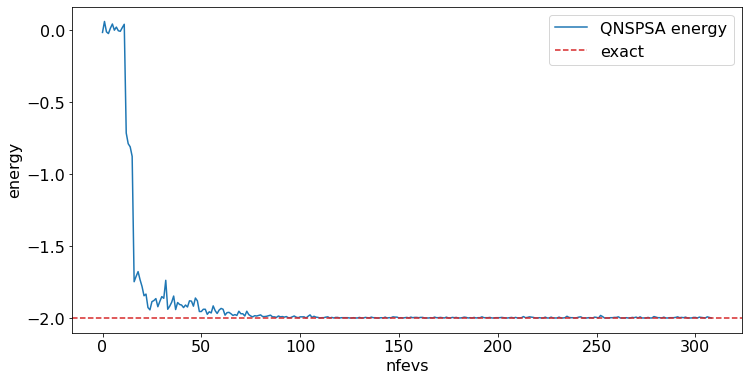

In [50]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["font.size"] = 16

# QNSPSA evaluates twice for the gradients, then once for the current value --> we plot that one
plt.figure(figsize=(12, 6))
plt.plot(loss[::3], label="QNSPSA energy")  
plt.axhline(y=exact_energy, color="tab:red", ls="--", label="exact")
plt.xlabel("nfevs")
plt.ylabel("energy")
plt.legend(loc="best")

### QN-SPSA with Qiskit Optimization & Qiskit Runtime

Now let's solve the same problem but on Qiskit Runtime and using the workflow of Qiskit's optimization module.

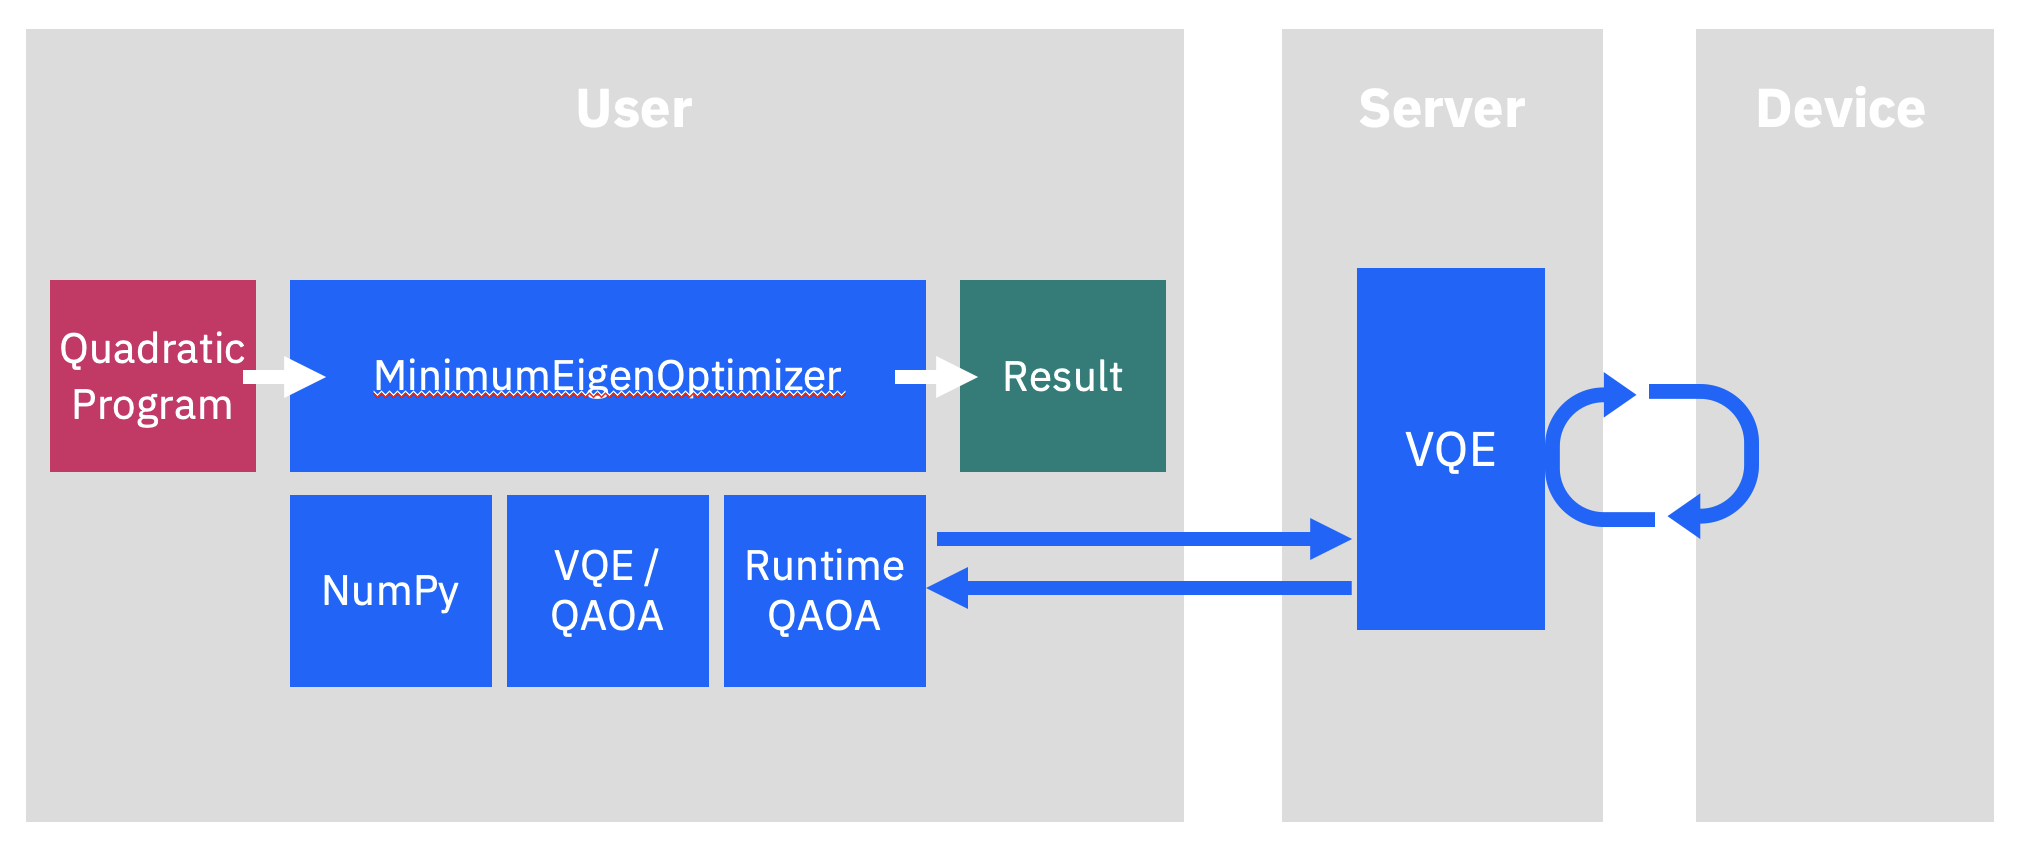

#### Simulator on the cloud

First, we have to select a provider and a backend.

In [ ]:
from qiskit.providers.ibmq import IBMQ

# load account and get backend
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_qasm_simulator')

Then, we can define the optimizer and the minimum eigensolver subroutine (of type `qiskit.algorithms.MinimumEigensolver`) to find the ground state. Here we'll use the QAOA runtime client to execute the program on the cloud.

In [ ]:
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.runtime import QAOAProgram

# Note that we don't have to set the `fidelity` function, this is set by the runtime program!
optimizer = QNSPSA(None,  # will be set by runtime
                   maxiter=300,
                   learning_rate=0.01,
                   perturbation=0.01)

# define the QAOA program executed on the cloud
qaoa = QAOAProgram(optimizer=optimizer,
                   provider=provider,
                   backend=backend,
                   shots=1024,
                   measurement_error_mitigation=True,
                   store_intermediate=True)

Now, we can plug the optimizer in the Qiskit Optimization workflow...

In [ ]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer

qp = QuadraticProgram()
qp.from_ising(H)

algo = MinimumEigenOptimizer(qaoa)

... and solve the problem:

In [55]:
result = algo.solve(qp)

In [56]:
print(result)

optimal function value: -2.0
optimal value: [1. 0. 0. 1. 0.]
status: SUCCESS


#### Real device: IBM Nairobi

In [71]:
from qiskit.providers.ibmq import IBMQ

# load account and get backend
IBMQ.load_account()
provider = IBMQ.get_provider(project='qiskit-runtime')
backend = provider.get_backend('ibm_nairobi')

ibmqfactory.load_account:WARNING:2021-12-01 11:05:38,634: Credentials are already in use. The existing account in the session will be replaced.


In [73]:
# define the QAOA program executed on the cloud
qaoa = QAOAProgram(optimizer=optimizer,
                   provider=provider,
                   backend=backend,
                   shots=1024,
                   measurement_error_mitigation=True,
                   store_intermediate=True)

algo = MinimumEigenOptimizer(qaoa)

In [ ]:
result_nairobi = algo.solve(qp)

In [ ]:
history_nairobi = result_nairobi.min_eigen_solver_result.optimizer_history

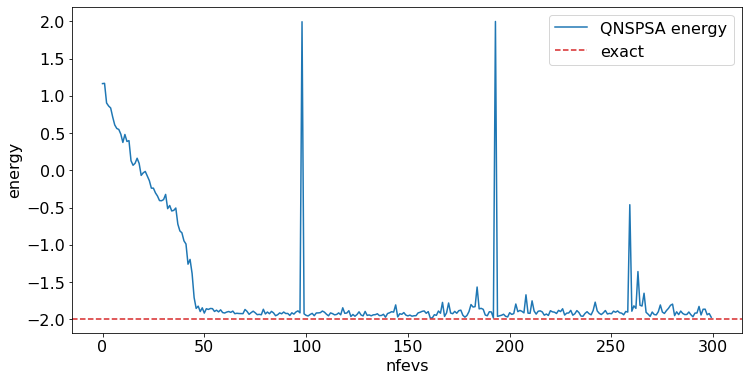

In [82]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["font.size"] = 16

# QNSPSA evaluates twice for the gradients, then once for the current value --> we plot that one
plt.figure(figsize=(12, 6))
plt.plot(history_nairobi["loss"], label="QNSPSA energy")  
plt.axhline(y=exact_energy, color="tab:red", ls="--", label="exact")
plt.xlabel("nfevs")
plt.ylabel("energy")
plt.legend(loc="best")

-----

In [ ]:
job_id = "c6jki5egkavn0ge0ic1g"
job = provider.runtime.job(job_id)
job_result = job.result()

print(job_result["eigenvalue"])
loss = job_result["optimizer_history"]["loss"]